# Plot timelines of ROH sharing
Plot individuals against their estimated age.
Input: Post-processed .csvs (pandas dfs) with individual ROH statistics and meta information (in particular age)

In [17]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Additional Imports
sys.path.append("./PackagesSupport/")
from sqrt_scale import SquareRootScale # Import Matplotlib sqrt scale

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Definie Plotting Function for Timelines

In [238]:
def plot_scatter_by_color(ax, age, roh, colors, labels, s, lw=1.0, ec="k", 
                          zorder=5, def_color="silver"):
    """Split up df per color, used to create legend
    (based on "clst" column). If default color (def_color) don't add label"""
    for c in pd.unique(np.array(colors)):
        idx = (colors == c)
        if c!=def_color:
            ax.scatter(age[idx], roh[idx], c=c, ec=ec, s=s, 
                   label=labels[idx][0], lw=lw, zorder=zorder)
        else:   # If default coor don't plot label
            ax.scatter(age[idx], roh[idx], c=c, ec=ec, s=s, zorder=zorder, lw=lw)
            
def plot_violin_ax(df, x=0, ax=0, figsize=(6,6), cm=4, cm1=0, widths=50, ec="k", c="yellow", 
                   alpha=0.5, zorder=0, col_median="red"):
    """Do a Violin Plot (usually on modern data)
    ax: If given plot on this Axis Object
    x: X Coordinate where to plot
    df: Dataframe containing on which x position to plot
    widths: With of the Violin"""
    ### Extract Data
    roh = df[f"sum_roh>{cm}"].values+0.1
    if len(c)==0:
        c = df["color"].values[0]
    if cm1>0:
        assert(np.sum(df[f"sum_roh>{cm}"].values < df[f"sum_roh>{cm1}"].values)==0)
        roh = (df[f"sum_roh>{cm}"].values+0.1) - df[f"sum_roh>{cm1}"].values
    
    if ax==0:  
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
    parts = ax.violinplot(roh, showmeans=False, positions=[x],
                       showmedians=False, showextrema=False, widths=widths)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(c)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)

    #quartile1, medians, quartile3 = np.percentile(roh, [25, 50, 75])
    #ax.scatter(x, medians, marker='o', color=col_median, s=20, zorder=3, label="Median Modern")
    #ax.vlines(x, quartile1, quartile3, color='k', linestyle='-', lw=5, label="25-75% Quartile Modern")

def plot_lowess_smoothing(df, cm=4, cm1=0, fs=14, fsl=10, fs_leg=7, ec="k", lw=1.0, ticks = [3539.39/16, 3539.39/64], tick_l=["1st C.", "2nd C."], 
                          figsize=(14,6), title="", dpi=300, savepath="",  xlim=[], ylim=[], s=40, frac=2/3, cust_c=True, 
                          labelpad=10, std_band=0, lgth_s=[500,2000], err_s=[2,4], max_f_age=0,
                          leg_loc="upper right", ax=0, swap_ax=True, show=True, xticks=False, rightcol=True):
    """Plot Lowess Smoothing of ROH vrs Age.
    df: Which Dataframe to use [standard pp format]
    cm: Length of blocks to plot. 
    cm1: Maximum block length to plot (if 0, none)
    savepath: If given save figure to there
    tot_l: Total length of accessible Chromosome [in cM]
    frac: Fraction Parameter to use for Lowess Smoothing.
    leg_loc: Where to plot the Legend. If no string given do not plot at all
    swap_ax: Whether to swap left/right tick axis
    std_band: How many standard deviations to plot (1.96. is 95%). If >0 use gp model
    lght_s: Length Scale of Gaussian Kernel to fit
    err_s: Error Scale of Gaussian Kernel to fit
    max_f_age: Maximum Age of sample to include in GP
    fs/fsl: Fontsize Axis / Fontsize Legend/Cousin Ticks
    lw: Linewidth in the Scatter Plot points
    ec: Edge Color of Scatter Plot points"""
    
    ### Extract what to plot from dataframe
    df = df.sort_values(by="age", ascending=False) # Sort by age from old to young
    age,roh,labels = df["age"].values, df[f"sum_roh>{cm}"].values+0.1, df["clst"].values
    if cm1>0:
        assert(np.sum(df[f"sum_roh>{cm}"].values < df[f"sum_roh>{cm1}"].values)==0)
        roh = (df[f"sum_roh>{cm}"].values+0.1) - df[f"sum_roh>{cm1}"].values
    c = "b" 
    if cust_c==True:
        c = df["color"].values
    
    ### Make new axis if none given
    if ax==0:  
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    plot_scatter_by_color(ax, age, roh, colors=c, labels=labels, 
                          s=s, lw=lw, ec=ec)
    
    if frac>0.0:
        z = lowess_sqrt(age, roh, frac=frac)
        plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", 
                 lw=2.5, zorder=1)
    
    if std_band>0:
        if max_f_age>0:
            idx = age<max_f_age
            age, roh = age[idx], roh[idx]
        x, y, y_up, y_down, y_up_mean, y_down_mean = fit_gp(age, roh, std_band=std_band, lgth_s=lgth_s, err_s=err_s)
        ax.plot(x, y, "k-", label=r"GP Estimation ($\sqrt{x}$)", 
                 lw=2.5, zorder=1)
        ax.fill_between(x, y_down, y_up, alpha=0.1, color='k', label=f"95% CI Point", zorder=0)
        ax.fill_between(x, y_down_mean, y_up_mean, alpha=0.25, color='k', label=f"95% CI Mean", zorder=0.5)
        
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if not xticks:
        ax.set_xticks([])
        
    if len(ylim)>0:
        ax.set_ylim(ylim)
        
    if len(leg_loc)>0:
        ax.legend(loc=leg_loc, fontsize=fs_leg)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)

    ### Horizontal Lines
    for i in range(len(ticks)):
        ax.axhline(ticks[i], color="gray", lw=0.5, ls="--")
        if len(tick_l)>0:
            ax.text(xlim[0], ticks[i], tick_l[i], fontsize=fsl, ha="right", va="bottom", zorder=0)
        
    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    
    ### Make left/right ticks (after Plotting!):
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    
    if swap_ax:
        ax, ax2 = ax2, ax # Hack to swap left and right
    
    ax2.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=fsl)
    #ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    # Do the original axis
    ax.set_xlabel("Age BP [years]", fontsize=fs)
    if rightcol:  # Plot only if right column
        if cm1>0:
            ax.set_ylabel(f"Sum ROH {cm}-{cm1} cM [cM]", fontsize=fs, rotation=270, labelpad=labelpad)
        elif cm1==0:
            ax.set_ylabel(f"Sum ROH >{cm} cM [cM]", fontsize=fs, rotation=270, labelpad=labelpad)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    
    if show:
        plt.show()

##########################################################################
### Functions to fit
def lowess_sqrt(x, y, frac=2/3):
    """Do a Lowess fitting on the sqrt.
    frac: parameter for lowess smoothing"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

def fit_gp(x, y, sqrt=True, in_lengthscale=1000, in_noise=2.0, 
           std_band = 1.96, lgth_s=[500, 2000], err_s=[2,4]):
    """Fit Gaussian Process.
    If sqrt: Take the square root for fit.
    Return: x, y, y_max, y_min"""
    if sqrt:
        y=np.sqrt(y)
    
    ### Sort Values
    idx =np.argsort(x)
    x=x[idx]
    y=y[idx]
        
    X = x[:, np.newaxis]
    kernel = 1.0 * RBF(length_scale=in_lengthscale, length_scale_bounds=lgth_s) \
                + WhiteKernel(noise_level=in_noise, noise_level_bounds=err_s)
    gp = GaussianProcessRegressor(kernel=kernel,
                                  alpha=0.0).fit(X, y)
    
    X_ = np.linspace(np.min(x), np.max(x), 1000)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    
    title = "Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s" % (kernel, gp.kernel_,
                 gp.log_marginal_likelihood(gp.kernel_.theta))
    print(title)
    y_up = y_mean + std_band * np.sqrt(np.diag(y_cov))
    y_down = y_mean - std_band * np.sqrt(np.diag(y_cov)) 
    
    error_var = gp.kernel_.get_params()["k2__noise_level"]
    stds = np.sqrt(np.diag(y_cov) - error_var)
    assert(np.min(stds)>=0)  # Sanity Check that Error in Mean is >0:
    y_up_mean =  y_mean + std_band * stds
    y_down_mean = y_mean - std_band * stds 
    
    if sqrt:
        y_mean, y_up, y_down = np.maximum(y_mean,0)**2, y_up**2, np.maximum(y_down,0)**2
        y_up_mean, y_down_mean = y_up_mean**2, np.maximum(y_down_mean,0)**2
        
    return X_, y_mean, y_up, y_down, y_up_mean, y_down_mean

####################################################
##### Helper Functions to prepare plotting Dataframes
def extract_pop(df, age_range=[], pop=""):
    """Assumes plotting Dataframe is pre-produced.
    Return Legend as well"""
    mod_idx = (df["age"]==0) ## Ancient Indices
    anc_idx = ~mod_idx
    if len(pop)>0:
        df = df[df["region"]==pop].copy()
    if len(age_range)>0:
        df = extract_df_age(df, age_range[0], age_range[1]).copy()
    return df

def prep_label(df, pop, only_mod=True):
    """Prepare a label string to use in legend.
    pop: Population that's going to be used"""
    n_mod = np.sum(df_t["age"]>0)
    label = f"{pop}\n(n={n_mod})"
    return label

# Functions to pre-process regional dataframes

### Plot Antonio

Saved to ./figures/manuscript/supplement/timelines/antonio.pdf


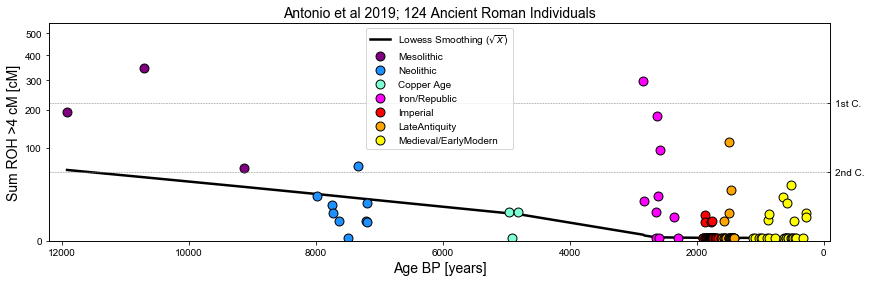

In [105]:
df1 = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df1 = pre_process_roman_df(df1, age_error=100, remove_sard=True)
plot_lowess_smoothing(df1, cm=4, ylim=[0,550], xlim=[-100, 12200], title=f"Antonio et al 2019; {len(df1)} Ancient Roman Individuals",
                      lowess=True, frac=0.8, figsize=(14,4), s=80, savepath="./figures/manuscript/supplement/timelines/antonio.pdf",
                      leg_loc="upper center")

# Do Plot Iberia with Olalde 2019

In [6]:
df_1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_2 = pd.read_csv("./Empirical/Eigenstrat/Olalde19/combined_roh05.csv", sep="\t")
df_c = pd.concat([df_1, df_2], ignore_index=True, sort=True).sort_values(by="sum_roh>4", ascending=False)
df_c = pre_process_iberia_df(df_c, age_error=50)
df_e = extract_sub_df_geo_kw(df_c,  35.95, 44, -10, 4, keywords = ["Iberia", "Portugal", "Spain"])

Found 136 Individuals; 118 from Geography


Found 134 Individuals; 116 from Geography
Saved to ./figures/manuscript/timelines/iberia.pdf


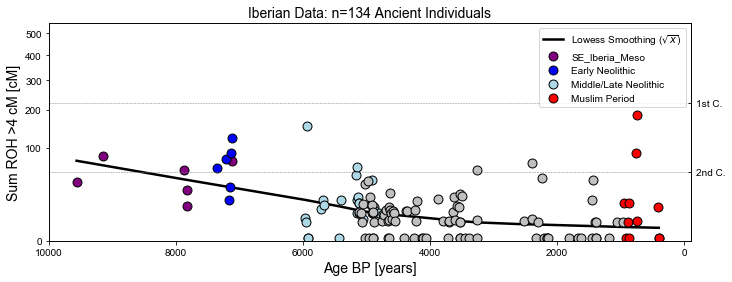

In [7]:
df_e = extract_df_age(df_e, 0, 15000)
df_e = extract_sub_df_geo_kw(df_e,  35.95, 44, -10, 4, keywords=["Iberia", "Portugal", "Spain"])

### Preprocess the Iberian data
plot_lowess_smoothing(df_e, cm=4, xlim=[-100, 10000], ylim=[0,550], title=f"Iberian Data: n={len(df_e)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(11.5, 4), s=80, savepath="./figures/manuscript/timelines/iberia.pdf", 
                      leg_loc="upper right")

# Plot both map and ROH timeline

### Function to plot the map

In [239]:
def plot_map_ax(df, ax, crs=[30, 60, -10, 40], s=40, vrange=[0, 7500], cmap="viridis_r", map_title="", title_loc=(0.1,0.1), lw=1.0, ec="k",
                fs_label=14, figsize=(12,11), states=False, annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", plot_mod=True, 
                vrange_a=[], mm=3.1, hspace=0.02, fs=18, col_cont = "#d9d9d9", col_lake = "#d9d9d9", show=True): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot
    lw: Width of Scatter point edges
    ec: Color of Scatter point edges"""
    if not plot_mod:
        df = df[df["age"]>0].copy() 
    lon, lat = df["lon"].values, df["lat"].values
    colors = df["age"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution='i', ax=ax)  # mill
    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    if states:
        m.drawstates()
        
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])
    ax.scatter(x, y, c=colors, ec=ec, lw=lw, s=s, cmap=cmap, norm=norm, zorder=3)
    
    if annotate:
        for i, txt in enumerate(df["iid"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)

    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    if len(map_title)>0:
        ax.text(title_loc[0], title_loc[1], map_title,
                fontsize=fs, transform=ax.transAxes, ha="left", va="bottom")
    if show:
        plt.show()
    
def plot_colorbar_age(ax, fs_label, cmap, vrange, xlim=[], labelpad=10, invert=True, bottomrow=True):
    """Code for plotting a colorbar of age onto axis Object"""
    if len(xlim)==0:
        xlim=vrange
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    cb1 = clb.ColorbarBase(ax, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label)
    ax.set_xlim(xlim)  #vrange
    if bottomrow:
        ax.set_xlabel('Age [years BP]', fontsize=fs_label, rotation=0, labelpad=labelpad)
    if invert:
        ax.invert_xaxis()
    
###########################################################
### Plot Map AND timeline in one plot

def plot_map_time(df, figsize=(20,4), width_ratios=[1,10], height_ratios=[20,1], wspace=0.02, hspace=0.03, ec="k", lw=1.0,
                  title_tl = "", s_tl=80,  x_lim_tl=[-100, 10000], y_lim_tl=[0,550], widths=50, alpha_vio=0.5, 
                  ticks = [3539.39/16, 3539.39/64], tick_l=["1st C.", "2nd C."], max_f_age=0,
                  leg_loc_tl="upper center", frac=0.8, cm=4, cm1=0, fs=10, fsl=10, fs_leg=7, std_band = 1.96, lgth_s=[2000,5000],
                  err_s=[2,4], vrange_m=[], cmap_m="viridis_r", crs_m=[30, 60, -10, 40], lbl_pad_age=10,
                  lbl_pad_time=5, map_title="", title_loc=(0.1,0.1), bottomrow=True, rightcol=True, plot_mod=False,
                  savepath=""):
    """Plot Map (Left) and Timeline (Right)
    df: Dataframe with input data on individual block sharing: Columns for sum>cm, age, and color
    _tl Arguments: Arguments for the Timeline.
    fs, fsl, fs_leg: Fontsize (general, labels & legend)
    cm: Minimum Block length shown
    cm1: Maximum Block length. (if 0 none)
    frac: Fraction for Lowess Smoothin (if 0 no lowess smoothing shown)
    savepath: Where to save (if given)
    cmap_m, vrange_m: Color Map (Keyword which one to use) and Range for Map Plots
    crs_m: Corners for the Map (Lat0, Lat1, Lon0, Lon1)-Vector
    lgth_s: Length scale of the Kerne to fit
    std_band: Standard Deviation of Estimate to plot
    ec: Edge Color of Scatter Plots
    lw: Line Width of Scatter Plots
    bottomrow: Whether plot is in bottom (plot xlabel then)
    rightcol: Same, but whether plot on right (plot ylabel then)
    alpha_vio: Alpha of the Violing Plot
    width: Width of Violin Plot for moderns""" 
    
    ### Extract Modern Idx
    idx_m = df["age"]==0
    
    ### Set Up the outer Figure Layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)
    ax_map = plt.subplot(gs[:,0])    # The left subplot (Timeline)
    ax_map_cb = plt.subplot(gs[1,1])
    ax_time = plt.subplot(gs[0,1])   # The right subplot (Timeline)
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Plot the Timeline (upper right)
    plot_lowess_smoothing(df, cm=cm, cm1=cm1, xlim=x_lim_tl, ylim=y_lim_tl, title=title_tl, fs=fs, fs_leg=fs_leg, max_f_age=max_f_age, 
                          lw=lw, ec=ec, fsl=fsl, std_band=std_band, lgth_s=lgth_s, err_s=err_s, frac=frac, s=s_tl, leg_loc=leg_loc_tl, 
                          ticks=ticks, tick_l=tick_l, ax=ax_time, labelpad=lbl_pad_time, show=False, rightcol=rightcol)
    
    ### Plot present-day indiviguals (upper right)
    if np.sum(idx_m)>0: # Only plot if modern Data exists
        plot_violin_ax(df[idx_m], x=0, ax=ax_time, widths=widths, alpha=alpha_vio,
                       cm=cm, cm1=cm1, zorder=0, c="")
    
    ### Plot the Map (left)
    if not plot_mod:
        df = df[~idx_m]
    plot_map_ax(df, ax=ax_map, crs=crs_m, cmap=cmap_m, vrange=vrange_m, map_title=map_title, show=False, 
                lw=lw, ec=ec, fs=fs, title_loc=title_loc, s=s_tl)
    ### Plot the Colorbar for the Map
    plot_colorbar_age(ax_map_cb, xlim=x_lim_tl, fs_label=fsl, cmap=cmap_m, vrange=vrange_m, labelpad=lbl_pad_age, 
                      bottomrow=bottomrow)
    
    ### Save
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

## Do various European Populations
Instructions: 
- Load the functions at top and just above.
- Then run the first cell that extracts all SA individuals.
- Then all panels that geographically subset

In [10]:
df_eu = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_eu = extract_sub_df_geo_kw(df_eu, 28, 63, -11, 38)
idx_flip = df_eu["iid"]=="I7554"
df_eu.loc[idx_flip, "lon"] = -df_eu.loc[idx_flip, "lon"]  # Flip Wrong Latitude Atlantic
idx_del = df_eu["iid"].str.contains("Loschbour")
df_eu = df_eu[~idx_del]

Found 664 Individuals; 664 from Geography


Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 5.12**2 * RBF(length_scale=5e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -1829.5439574126326


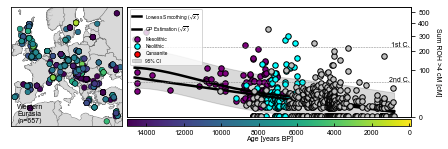

In [256]:
### Plot all of Europe (not necessary in fow)
df_eu["color"] = "silver"
df_1 = pre_process_europe_df(df_eu)
df_1 = extract_df_age(df_1, 0, 15000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 15000], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Western\nEurasia\n(n={len(df_1)})", title_loc=(0.06,0.02), frac=0.9)

# Produce European Panels (8 Figures, main manuscript)

### Italy (Antonio et al. 2019) [Figure 1 is Legacy from earlier]

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 4.33**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -225.41976365843826
Saved to ./figures/manuscript/timelines/eu_panel/roman1.pdf


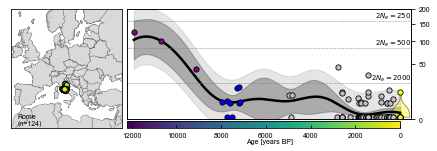

In [233]:
pop = "Rome"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=True, rightcol=False,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/roman1.pdf")

### Iberia (Olalde et al. 2019)

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.91**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.36)
Log-Marginal-Likelihood: -425.7105989963873
Saved to ./figures/manuscript/timelines/eu_panel/iberia1.pdf


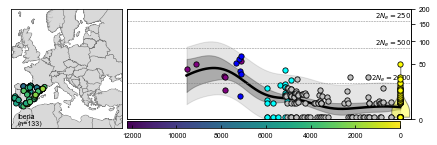

In [234]:
pop = "Iberia"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=False,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/iberia1.pdf")

### Do the Balkans

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.97**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.33)
Log-Marginal-Likelihood: -324.9188835451141
Saved to ./figures/manuscript/timelines/eu_panel/balkans1.pdf


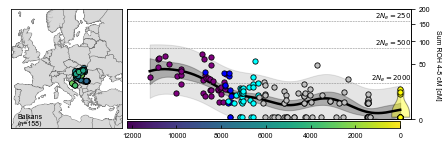

In [235]:
pop = "Balkans"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/balkans1.pdf")

### Do Anatolia / Greece

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.18**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -235.4993613413338
Saved to ./figures/manuscript/timelines/eu_panel/aegan1.pdf


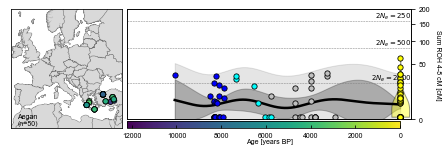

In [236]:
pop = "Aegan"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=True, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/aegan1.pdf")

### Central Europe

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 3.26**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -262.93447621560415
Saved to ./figures/manuscript/timelines/eu_panel/ce1.pdf


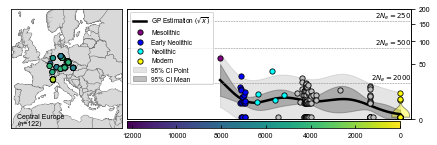

In [241]:
pop = "Central Europe"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, fs_leg=6.5, leg_loc_tl="upper left", 
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=False,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/ce1.pdf")

### Ukraine

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 3**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.42)
Log-Marginal-Likelihood: -68.2939279819931
Saved to ./figures/manuscript/timelines/eu_panel/ukraine1.pdf


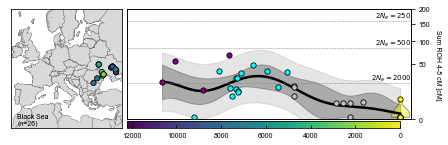

In [242]:
pop = "Black Sea"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/ukraine1.pdf")

### North Africa [not in final version, too few samples]

Found 4 Individuals; 4 from Geography
Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 7.17**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.35)
Log-Marginal-Likelihood: -9.642288648216601
Saved to ./figures/manuscript/timelines/eu_panel/n_afr.pdf


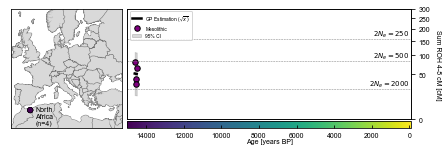

In [287]:
df_1 = extract_sub_df_geo_kw(df_eu,  26, 36, -11, 25)
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 22000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 15000], y_lim_tl=[0,300], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"North\nAfrica\n(n={len(df_1)})", title_loc=(0.22,0.02), frac=0.0, cm=4, cm1=8, lgth_s=[2000,2000],
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/eu_panel/n_afr.pdf")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 6.65**2 * RBF(length_scale=2.5e+03) + WhiteKernel(noise_level=3.21)
Log-Marginal-Likelihood: -116.72238449925189
Saved to ./figures/manuscript/timelines/eu_panel/n_afr.pdf


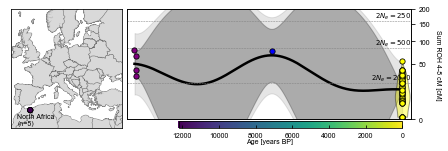

In [192]:
pop = "North Africa"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,15000], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 15000], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[2500,2500], bottomrow=True, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/n_afr.pdf")

### Britain

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 1.77**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -269.6872563953925
Saved to ./figures/manuscript/timelines/eu_panel/britain1.pdf


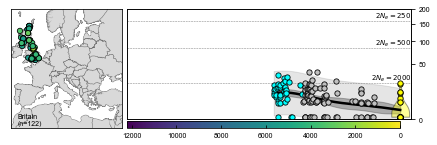

In [244]:
pop = "Britain"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=False,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/britain1.pdf")

### Baltic

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 3.22**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.28)
Log-Marginal-Likelihood: -162.45792322638675
Saved to ./figures/manuscript/timelines/eu_panel/baltic1.pdf


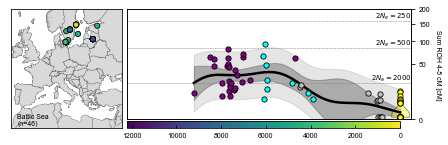

In [245]:
pop = "Baltic Sea"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=False, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/baltic1.pdf")

### Sardinia

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 1.94**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.25)
Log-Marginal-Likelihood: -141.3007754846259
Saved to ./figures/manuscript/timelines/eu_panel/sardinia1.pdf


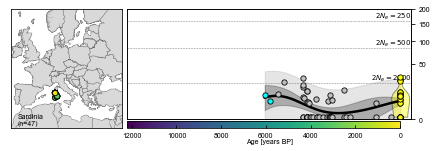

In [246]:
pop = "Sardinia"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=True, rightcol=False,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/sardinia1.pdf")

### Sardinia with full dataset [SIDE QUEST]

In [92]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_sard = df1[df1["region"]=="Sardinia"].copy()
#df_sard = df_sard[df_sard["age"]>0]
df_sard.loc[df_sard["color"].values.astype("str")=="nan", "color"]="gray"
df_sard.loc[df_sard["age"]==0, "color"] = "white"
df_sard.loc[df_sard["age"]==0, "clst"] = "Modern"
df_sard.loc[df_sard["clst"]=="(not included in analyses)", "color"]="orange"
df_sard.loc[df_sard["clst"]=="(not included in analyses)", "clst"]="Antonio et al."
### 

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.07**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.26)
Log-Marginal-Likelihood: -140.98317237909237
Saved to ./figures/manuscript/timelines/eu_panel/sardinia_all.pdf


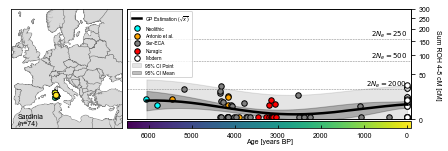

In [93]:
plot_map_time(df_sard, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 6500], y_lim_tl=[0,300], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Sardinia\n(n={len(df_sard)})", title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, std_band=1.96, lgth_s=[2000, 2000],
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/eu_panel/sardinia_all.pdf")

## Levante

### With Levante Boarders

Found 21 Individuals; 21 from Geography
Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.63**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.61)
Log-Marginal-Likelihood: -44.15892318872749
Saved to ./figures/manuscript/timelines/eu_panel/levant.pdf


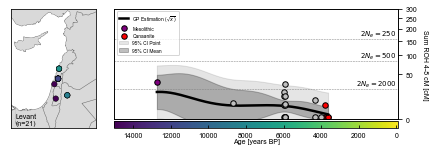

In [46]:
df_1 = extract_sub_df_geo_kw(df_eu, 30, 37, 32, 38, keywords = ["Levant", "Israel", "Canaanite"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 20000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[30, 37, 32, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 15000], y_lim_tl=[0,300], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Levant\n(n={len(df_1)})", title_loc=(0.06,0.02), frac=0.0, cm=4, cm1=8, std_band=1.96, lgth_s=[2000,2000],
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/eu_panel/levant.pdf")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 2.23**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -396.3248960138699
Saved to ./figures/manuscript/timelines/eu_panel/levant1.pdf


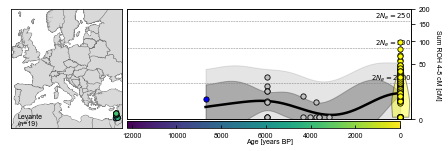

In [247]:
pop = "Levante"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-500, 12200], vrange_m=[0,12200], y_lim_tl=[0,200], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[1500,1500], bottomrow=True, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/eu_panel/levant1.pdf")

## Bonus Areas

### Vanuatu

Found 24 Individuals; 24 from Geography
Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 4.07**2 * RBF(length_scale=2.2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -56.45838924617519
Saved to ./figures/manuscript/timelines/eu_panel/vanuatu.pdf


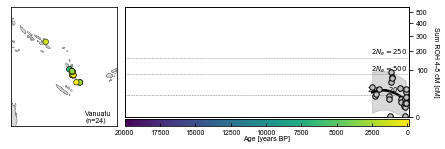

In [8]:
df_w = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_1 = extract_sub_df_geo_kw(df_w, -30, -5, 155, 180, keywords = ["Vanuatu"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 20000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[-30, 0, 152, 180], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 20000], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=f"Vanuatu\n(n={len(df_1)})", title_loc=(0.7, 0.02), frac=0.0, std_band=1.96, cm=4, cm1=8,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/eu_panel/vanuatu.pdf")

### Eurasian Steppe

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 6.95**2 * RBF(length_scale=6e+03) + WhiteKernel(noise_level=2.99)
Log-Marginal-Likelihood: -378.61940309329634
Saved to ./figures/manuscript/timelines/steppe_all.pdf


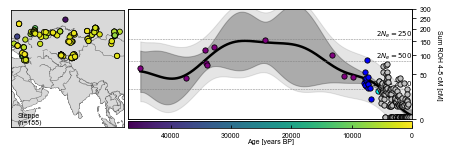

In [259]:
pop = "Steppe"
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 47000], pop=pop)
label = prep_label(df_t, pop)

#df_ib = extract_df_age(df_ib, 0, 12200)
plot_map_time(df_t, figsize=(7.2 , 2.2), crs_m=[0, 61, 35, 110], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=28, 
              ec="k", lw=0.8, x_lim_tl=[-100, 47000], vrange_m=[-100, 47000], y_lim_tl=[0,300], lbl_pad_age=0, lbl_pad_time=11, 
              fsl=7, fs=7, leg_loc_tl="",
              map_title=label, title_loc=(0.06,0.02), frac=0, cm=4, cm1=8, title_tl="", lgth_s=[6000,6000], bottomrow=True, rightcol=True,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"], widths=800, alpha_vio=0.4,
              savepath="./figures/manuscript/timelines/steppe_all.pdf")

# South American Populations
Instructions: 
- Load the functions at top and just above.
- Then run the first cell that extracts all SA individuals.
- Then all panels that geographically subset

In [43]:
### Overview
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
sa_corners = [-59, 57, -130, -32]
df_e.loc[df_e["iid"]=="Aconcagua.SG", "lat"] = -32.65  # Flip Wrong Latitude (32.64 is in Atlantic)
df_e["color"] = "silver"
df_e["clst"] = "Ancient Individual"
df_e = extract_df_geo(df_e, -60, 55, -130, -30).copy()  # Make a new Copy. America

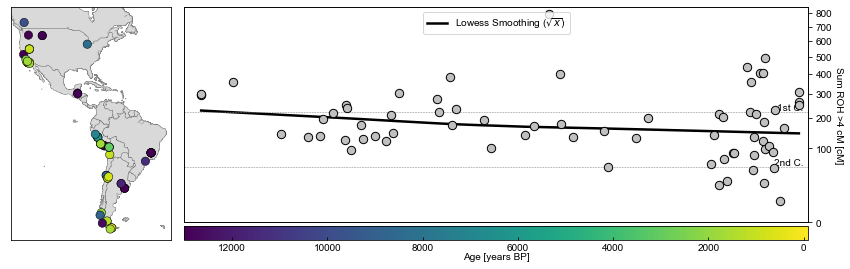

In [292]:
plot_map_time(df_e, figsize=(14.4 , 4.3), crs_m=sa_corners, width_ratios=(5.5, 20), height_ratios=[15, 1],
              x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, s_tl=70)

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 9.32**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -20.259854531145223
Saved to ./figures/manuscript/timelines/sa_panel/fuego.pdf


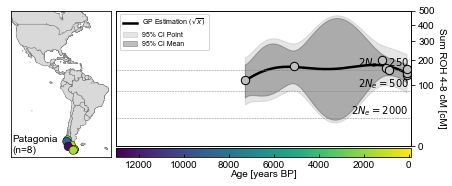

In [44]:
### Patagonia
df_sa = extract_df_geo(df_e, -60, -41, -130, -30).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0, 500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, leg_loc_tl="upper left",
              map_title=f"Patagonia\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70, cm=4, cm1=8, lgth_s=[2000,2000], 
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/sa_panel/fuego.pdf")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 9**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -72.38163217785544
Saved to ./figures/manuscript/timelines/sa_panel/and.pdf


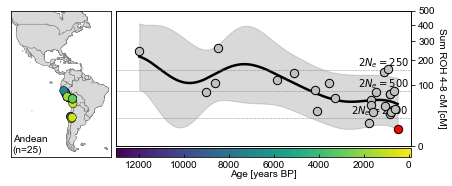

In [278]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -41, 10, -130, -63).copy()  # Make a new Copy. America
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "color"]="red"  
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "clst"]="Inca_500BP" 
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, 
              leg_loc_tl="", map_title=f"Andean\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70, cm=4, cm1=8,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              std_band=1.96, lgth_s=[2000,2000], savepath="./figures/manuscript/timelines/sa_panel/and.pdf")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 8.38**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -46.47355945446203
Saved to ./figures/manuscript/timelines/sa_panel/pac_nw.pdf


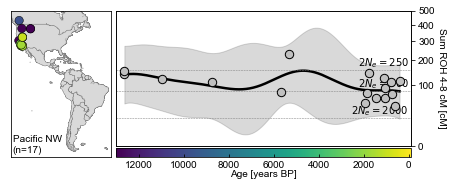

In [279]:
### Pacific NW
df_sa = extract_df_geo(df_e, 30, 55, -130, -95).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, 
              leg_loc_tl="", map_title=f"Pacific NW\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              cm=4, cm1=8, lgth_s=[2000,2000], ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/sa_panel/pac_nw.pdf")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 7.52**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.84)
Log-Marginal-Likelihood: -35.28305452233681
Saved to ./figures/manuscript/timelines/sa_panel/atl_coast.pdf


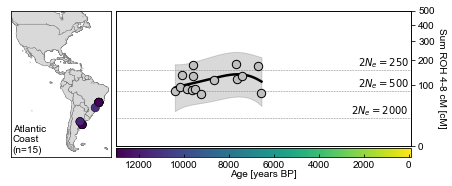

In [280]:
### Atlandic coast
df_sa = extract_df_geo(df_e, -41, 10, -63, -30).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              x_lim_tl=[-100, 13000], y_lim_tl=[0,500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, leg_loc_tl="",
              map_title=f"Atlantic\nCoast\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70, cm=4, cm1=8,
              lgth_s=[2000,2000], ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              savepath="./figures/manuscript/timelines/sa_panel/atl_coast.pdf")

# Area 51

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 13**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -26.813972133107193


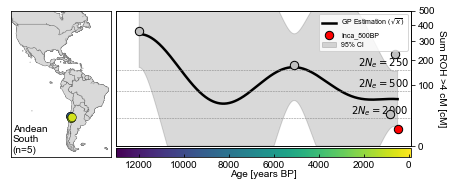

In [149]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -41, -26, -130, -63).copy()  # Make a new Copy. America
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "color"]="red"  
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "clst"]="Inca_500BP"  
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, 
              leg_loc_tl="upper right", map_title=f"Andean\nSouth\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              lgth_s=[2000,2000], savepath="")

Initial: 1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=2)
Optimum: 10.6**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -73.11916831473992


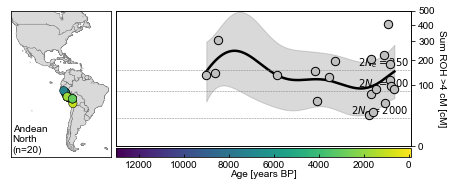

In [150]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -26, 10, -130, -63).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,500], lbl_pad_age=0, lbl_pad_time=11, frac=0.0, 
              leg_loc_tl="", map_title=f"Andean\nNorth\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              ticks=[158.74, 83.82, 21.84], tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"],
              lgth_s=[2000,2000], savepath="")

# Legacy [Delete if no longer needed]

In [8]:
def pre_process_roman_df(df, age_error=0, remove_sard=False):
    """Preprocess and return roman df and adds colors"""
    color_dict = {"Medieval/EarlyModern":"yellow", "Imperial":"red", "Iron/Republic":"magenta", "LateAntiquity":"orange", 
              "Copper Age":"aquamarine", "Neolithic":"dodgerblue", "Mesolithic":"purple", "(not included in analyses)":"gray"}
    df["color"] = df["clst"].map(color_dict)
    if age_error>0:
        df["age"]+= np.random.random(len(df))*age_error - age_error/2
        
    ### Remove the 
    if remove_sard:
        del_idx = (df["clst"] == "(not included in analyses)")
        df = df[~del_idx]
    return df

def pre_process_iberia_df(df, age_error=0):
    """Preprocess and return roman df and adds colors"""
    df["color"]="silver"

    ### WHG Coloring
    hg_terms = ["HG", "Meso", "ElMiron"]
    idx = df["clst"].str.contains('|'.join(hg_terms))
    df.loc[idx, "color"]="purple"
    df.loc[idx, "clst"]="Mesolithic"
    
    ### EN Coloring
    en_terms = ["Iberia_EN"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="blue"
    df.loc[idx,"clst"]="Early Neolithic"
    
    ### Middle Late Neoltihic
    mn_terms = ["MN", "MLN", "MN", "LN"]
    idx = df["clst"].str.contains('|'.join(mn_terms))
    df.loc[idx,"color"]="lightblue"
    df.loc[idx,"clst"]="Middle/Late Neolithic"
    
    ### Muslim Burials
    en_terms = ["SE_Iberia_c.10-16CE"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Muslim Period"
        
    if age_error>0:
        df["age"]+= np.random.random(len(df)) * age_error - age_error/2      
    return df

def pre_process_europe_df(df, age_error=0):
    """Preprocess and return roman df and adds colors"""
    ### WHG Coloring
    hg_terms = ["HG", "Meso", "ElMiron", "Iron Gates", "Loschbour"]
    idx = ((df["clst"].str.contains('|'.join(hg_terms))) | (df["age"]>10500)) & (df["age"]>5000)
    df.loc[idx,"color"]="purple"
    df.loc[idx,"clst"]="Mesolithic"
    
    ### EN Coloring
    en_terms = ["EN", "Early Neol", "Neolithic", "Cardial", "MN", "LN", "MLN", "Ukraine_N", "Peloponnese_N"]
    idx = df["clst"].str.contains('|'.join(en_terms)) & (df["age"]>5500)
    df.loc[idx,"color"] = "aqua"
    df.loc[idx,"clst"] = "Neolithic"
    
    ### Middle Late Neoltihic
    #mn_terms = ["MN", "MLN", "MN", "LN", "Early Neolithic"]
    #idx = df["clst"].str.contains('|'.join(mn_terms))
    #df.loc[idx,"color"]="lightblue"
    #df.loc[idx,"clst"]="Farmers"
    
    ### Antatolia Farmers
    en_terms = ["Anatolia_N", "Anatolia Farmers"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="blue"
    df.loc[idx,"clst"]="Anatolia Farmers"
    
    en_terms = ["Canaanite"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Canaanite"
    
    en_terms = ["Sar-Nur"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Nuragic"
    
    en_terms = ["skythian", "Skythian"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="orange"
    df.loc[idx,"clst"]="Skythian"
    
    if age_error>0:
        df["age"]+= np.random.random(len(df)) * age_error - age_error/2
        
    return df

In [9]:
def extract_df_geo(df, lat0, lat1, lon0, lon1):
    """Extract Dataframe df from Sub Data frame based on coordinates
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    lat_okay = (df["lat"]>lat0) & (df["lat"]<lat1)
    lon_okay = (df["lon"]>lon0) & (df["lon"]<lon1)
    df_s = df[lat_okay & lon_okay]
    return df_s

def extract_df_age(df, age0, age1=1e6):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

def give_df_clsts(df, search=[], col="pop"):
    """Return sub dataframe within df
    where in col one of search strings (list of string)"""
    if len(search)>0:
        idx = df[col].str.contains('|'.join(search)) # Find
        df = df[idx]
    else:
        df=df[0:0]
    return df

def extract_sub_df_geo_kw(df, lat0, lat1, lon0, lon1, keywords=[]):
    """Extract Dataframe df from Sub Data frame based on coordinates
    AND from keywords
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    df1 = extract_df_geo(df, lat0, lat1, lon0, lon1).copy()  # Make a new Copy. America
    df2 = give_df_clsts(df, search=keywords) 
    df_m = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
    print(f"Found {len(df_m)} Individuals; {len(df1)} from Geography")
    return df_m

### Legacy Code for Summary Statistics [Delete if not needed anymore, keep code for future reference]

In [13]:
en_terms = ["Anatolia Farmers"]
idx = df_eu["clst"].str.contains('|'.join(en_terms))
df_anatolia = df_eu[idx]
zero_roh = np.sum(df_anatolia["n_roh>4"]==0)
print(f"Anatolia Farmers: {zero_roh} / {len(df_anatolia)} have 0 ROH > 4 cM")

Anatolia Farmers: 0 / 0 have 0 ROH > 4 cM


In [ ]:
### Fraction of whole European dataset with ROH > 150 cM
zero_roh = np.sum(df_eu["sum_roh>4"]>150)
print(f"All: {zero_roh} / {len(df_eu)} have 150 cM ROH > 4 cM")

### Same for WHG
#en_terms = ["Hunter Gatherers"]
#idx = df_euro["clst"].str.contains('|'.join(en_terms))
idx = (df_eu["color"]=="purple")
df_anatolia = df_eu[idx]
zero_roh = np.sum(df_anatolia["sum_roh>4"]>150)
print(f"Hunter Gatherers: {zero_roh} / {len(df_anatolia)}  have 150 cM ROH > 4 cM")

# Area 51